# Oversampling and impact on SNR

In [1]:
%matplotlib inline
# To create the slider
from ipywidgets import interact
# We will be using numpy
import numpy as np
# We will be using matplotlib for plotting
import matplotlib.pyplot as plt
# We will be using scipy.signal for filtering
import scipy.signal as scipy_signal
from pylab import *

In [2]:
fs=1024; #sampling frequency in Hz
f=[400] #list of frequencies of sine waves that will make the signal waveform
t=2; #time for the signal

We will create a signal which will be a sine of all the frequencies in the list 'f'. You can add your own frequencies to the list

In [3]:
num_samples=int(fs*t)
sample_indices=np.arange(num_samples)
time_indices=sample_indices/fs
signal=np.zeros(num_samples,dtype=float)
signal_power=20*np.log10(0.5);
for frequency in f:
    signal=signal+np.sin(2*np.pi*frequency*sample_indices/fs)

#This is just the peak to peak value for the signal
full_scale_range=np.max(signal)-np.min(signal)

Lets plot the signal and see how it looks like:

Text(0.5, 0, 'Time(s)')

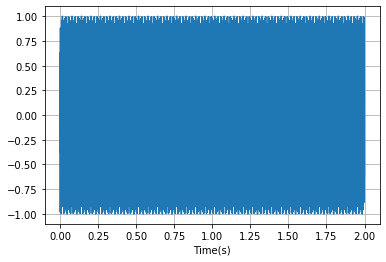

In [4]:
plt.figure()
plt.plot(time_indices,signal)
plt.grid()
plt.xlabel('Time(s)')

Lets do a FFT of the signal and see the result.`

Text(0.5, 0, 'Frequencies(Hz)')

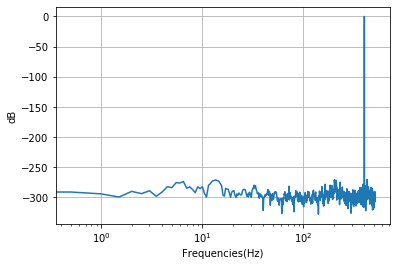

In [5]:
signal_fft=np.fft.fft(signal)
signal_fft_magnitude=20*np.log10(np.absolute(signal_fft)/(0.5*signal.size))

frequency_axis=np.fft.fftfreq(signal.size,d=1.0/fs)
plt.figure()
plt.semilogx(frequency_axis[0:signal_fft.size//2],signal_fft_magnitude[0:signal_fft.size//2])
plt.grid()
plt.ylabel('dB')
plt.xlabel('Frequencies(Hz)')


You can see the SNR is quite high (300 dB!!).. This is to be expected because there is no noise in the signal. 

## SNR after quantization

Unfortunately, numpy does not provide a quantizer. But its easy to make a quantizer function.

In [6]:
def quantizer(signal,quantization_step):
    #This is a half step quantizer. Note that we are just quantizing the signal and not converting it into any codes
    return quantization_step*np.round(signal/quantization_step)

Because Python does not have an in-built SNR function, we need to write our SNR function.

In [7]:
def signal_to_noise(signal, signal_plus_noise):
    noise=signal_plus_noise-signal;
    signal_plus_noise_power=np.sum(np.square(signal_plus_noise))/signal.size
    signal_power=np.sum(np.square(signal))/signal.size
    noise_power=np.sum(np.square(noise))/signal.size
    return (10*np.log10(signal_power),10*np.log10(signal_power/noise_power))

We will define a function that takes the number of bits of a quantizer as an input and generates the FFT of the output of the quantizer. We are doing this so that we can use the slider to change the value of bits of the quantizer and see the impact on FFT

In [8]:
def quantization_output(bits_quantizer):
    quantization_step=full_scale_range/(2**bits_quantizer)
    signal_quantized=quantizer(signal,quantization_step)

    #First lets plot the quantized signal
    #plt.figure()
    #plt.plot(time_indices,signal_quantized,time_indices,signal)
    #plt.grid()
    #plt.xlabel('Time(s)')

    theoretical_snr=(6.02*bits_quantizer)+1.76;
    (signal_power,snr)=signal_to_noise(signal,signal_quantized)
    print('Signal power is {}dB'.format(signal_power))
    print('SNR is {} dB'.format(snr))
    print('Theoretical SNR is {} dB'.format(theoretical_snr))
    #Lets take the FFT and see the result
    signal_quantized_fft=np.fft.fft(signal_quantized)
    signal_quantized_fft_magnitude=20*np.log10(np.absolute(signal_quantized_fft)/(0.5*signal_quantized.size)+1e-16)
    #the addition of 1e-16 at the end is done so that log10 function from numpy package does not crap out
    
    plt.figure()
    plt.semilogx(frequency_axis[0:signal_quantized_fft.size//2],signal_quantized_fft_magnitude[0:signal_fft.size//2])
    plt.grid()
    plt.ylabel('dB')
    plt.xlabel('Frequencies(Hz)')

#add a slider to play around with the number of bits in the quantizer
interact(quantization_output,bits_quantizer=(1,24));

interactive(children=(IntSlider(value=12, description='bits_quantizer', max=24, min=1), Output()), _dom_classe…

In [9]:
def oversampling_adc(order,bits_quantizer=12):
    #In this function we will oversample the signal and see the impact of oversampling on SNR
    fs_oversampled=fs*(2**order)
    num_oversampled_samples=int(t*fs_oversampled)
    sample_oversampled_indices=np.arange(num_oversampled_samples)
    time_oversampled_indices=sample_indices/fs_oversampled
    signal_oversampled=np.zeros(num_oversampled_samples,dtype=float)
    for frequency in f:
        signal_oversampled=signal_oversampled+np.sin(2*np.pi*frequency*sample_oversampled_indices/fs_oversampled)

    # One might be tempted to ask why not just take the original signal and interpolate it.
    # There are two reasons why it would be wrong:
    # --> Interpolation is sort of a filtering which will add its own frequency domain artifacts
    # --> That is not how oversampling works in real life. 
    
    # Lets quantize the signal
    quantization_step=full_scale_range/(2**bits_quantizer)
    oversampled_quantized=quantizer(signal_oversampled,quantization_step)
    (signal_power,snr)=signal_to_noise(signal_oversampled,oversampled_quantized)
    print('Signal power is {}dB'.format(signal_power))
    print('SNR is {} dB'.format(snr))
    
    # Lets do a FFT on the signal
    oversampled_fft=np.fft.fft(oversampled_quantized)
    oversampled_fft_magnitude=20*np.log10((np.absolute(oversampled_fft)/(0.5*oversampled_fft.size))+1e-16)
    oversampled_frequency_axis=np.fft.fftfreq(signal_oversampled.size,d=1.0/fs_oversampled)
    plt.figure()
    plt.grid()
    plt.semilogx(oversampled_frequency_axis[0:oversampled_frequency_axis.size//2],oversampled_fft_magnitude[0:oversampled_frequency_axis.size//2])
    plt.ylabel('dB')
    plt.xlabel('Frequency(Hz)')
    plt.ylim([-150,10])
interact(oversampling_adc,order=(1,6))

    

interactive(children=(IntSlider(value=3, description='order', max=6, min=1), IntSlider(value=12, description='…

<function __main__.oversampling_adc(order, bits_quantizer=12)>

See that oversampling has done nothing to the SNR. But you can see that the signal is in the far left of the plot. There is not a lot of information on the right hand side. We can filter those components out and see the impact on SNR. 

## Oversampling with a filter

In [10]:
def oversampling_adc_with_filter(order,bits_quantizer=12):
    #In this function we will oversample the signal and see the impact of oversampling on SNR
    fs_oversampled=fs*(2**order)
    num_oversampled_samples=int(t*fs_oversampled)
    sample_oversampled_indices=np.arange(num_oversampled_samples)
    time_oversampled_indices=sample_indices/fs_oversampled
    signal_oversampled=np.zeros(num_oversampled_samples,dtype=float)
    for frequency in f:
        signal_oversampled=signal_oversampled+np.sin(2*np.pi*frequency*sample_oversampled_indices/fs_oversampled)

    # One might be tempted to ask why not just take the original signal and interpolate it.
    # There are two reasons why it would be wrong:
    # --> Interpolation is sort of a filtering which will add its own frequency domain artifacts
    # --> That is not how oversampling works in real life. 
    
    # Lets quantize the signal
    quantization_step=full_scale_range/(2**bits_quantizer)
    oversampled_quantized=quantizer(signal_oversampled,quantization_step)
    (signal_power,snr)=signal_to_noise(signal_oversampled,oversampled_quantized)
    print('------ Before filtering ------')
    print('Signal power is {}dB'.format(signal_power))
    print('SNR is {} dB'.format(snr))
    print(' -----------------------------')
    
    # Lets add a low pass filter with 256 taps, cut-off frequency as twice the maximum frequency in the list 'f'
    fir_filter=scipy_signal.firwin(256,500,fs=fs_oversampled)
    plt.figure()
    w,h=scipy_signal.freqz(fir_filter,fs=2*np.pi*fs_oversampled)
    w=w/(2*np.pi)
    filtered_signal=scipy_signal.convolve(oversampled_quantized,fir_filter,mode='same',method='direct')
    filtered_signal=filtered_signal[0:oversampled_quantized.size]
    
    #Lets find the SNR after filtering
    (signal_power,snr_filtered)=signal_to_noise(signal_oversampled,filtered_signal)

    print('------ After filtering ------')
    print('Signal power is {}dB'.format(signal_power))
    print('SNR is {} dB'.format(snr_filtered))
    print(' -----------------------------')
    
    
    # Lets do a FFT on the signal
    filtered_signal_fft=np.fft.fft(filtered_signal)
    filtered_signal_fft_magnitude=20*np.log10((np.absolute(filtered_signal_fft)/(0.5*filtered_signal_fft.size))+1e-16)
    oversampled_frequency_axis=np.fft.fftfreq(signal_oversampled.size,d=1.0/fs_oversampled)
    plt.figure()
    plt.grid()
    plt.semilogx(oversampled_frequency_axis[0:oversampled_frequency_axis.size//2],filtered_signal_fft_magnitude[0:oversampled_frequency_axis.size//2])
    plt.ylabel('dB')
    plt.xlabel('Frequency(Hz)')
    plt.ylim([-150,10])
    k=np.where(frequency_axis==f[0])
interact(oversampling_adc_with_filter,order=(1,6))

interactive(children=(IntSlider(value=3, description='order', max=6, min=1), IntSlider(value=12, description='…

<function __main__.oversampling_adc_with_filter(order, bits_quantizer=12)>

As you can see here, the signal appears to be much cleaner. But then why is the SNR so bad?
It is because the way we have defined the SNR function. We defined noise as the time difference between (signal + quantization noise) and signal. The problem with that approach appears when we are trying to filter the signal. Filtering the signal introduces delay between the original signal and the filtered signal. That will come as noise which will be incorrect.